### Problem Description

### This dataset consists of reviews of fine foods from amazon. and we want to do sentiment analysis on the data to know either the review is positive or negative.
### here is the link of the dataset --> https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

In [85]:
!pip3 install gensim==3.8.3

### Import Packages

In [86]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read Dataset

In [87]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 4.02 s


In [88]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [89]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [90]:
df_text = df.drop_duplicates()
df_text.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [91]:
condlist = [df_text['Score'] <3, df_text['Score'] >=3]
choicelist = [0, 1]
df_text['target'] = np.select(condlist, choicelist)

#### Plot Countplot for target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

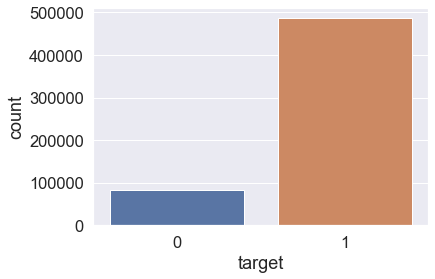

In [92]:
sns.countplot(data = df_text , x = 'target')  

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [93]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])
df_text_balanced.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
420622,420623,B008JKSJJ2,A33IKMXLPRPB5A,E. Reichert,3,3,5,1309910400,Kind Cranberry Almond Bars,I really like all the Kind bar flavors but the...,1
251572,251573,B001SITYJ6,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,4,1279152000,Good Fresh Jerky,I have found this brand to be more fresh than ...,1
8444,8445,B003VXFK44,AR92LPQMUOABQ,Pinky,0,0,5,1327017600,Best darn coffee :),I love this coffee - it's one of my all time f...,1
438183,438184,B000FFIEL2,A1FS3GMCEMFB2Q,Sara,4,5,3,1234742400,"Not impressed~ boring, & weak lime",I didn't really like this soup as I found it r...,1
90036,90037,B003ZTCINA,A2WQWY1210ASAC,C. Holster,9,10,5,1284508800,Product is wonderful but this package is way o...,These granola thins are a great product. Abso...,1


<AxesSubplot:xlabel='target', ylabel='count'>

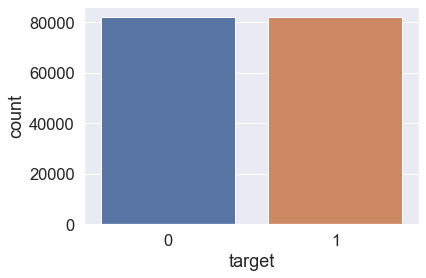

In [94]:
# PLot the target again after balancing
sns.countplot(data = df_text_balanced , x = 'target')  

### Text Pre-Processing

In [95]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

### Clean your reviews using stemmer, lemmatizer & stopwords

In [97]:
#Remove stop words 
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in text.split() if word not in stop_words])
df_text_balanced["Text"] = df_text_balanced["Text"].apply(lambda text: remove_stopwords(text))
df_text_balanced.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
420622,420623,B008JKSJJ2,A33IKMXLPRPB5A,E. Reichert,3,3,5,1309910400,Kind Cranberry Almond Bars,I really like Kind bar flavors Cranberry Almon...,1
251572,251573,B001SITYJ6,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,4,1279152000,Good Fresh Jerky,I found brand fresh others. The jerky somewhat...,1
8444,8445,B003VXFK44,AR92LPQMUOABQ,Pinky,0,0,5,1327017600,Best darn coffee :),I love coffee - one time favorites - best flav...,1
438183,438184,B000FFIEL2,A1FS3GMCEMFB2Q,Sara,4,5,3,1234742400,"Not impressed~ boring, & weak lime",I really like soup I found rather boring eat. ...,1
90036,90037,B003ZTCINA,A2WQWY1210ASAC,C. Holster,9,10,5,1284508800,Product is wonderful but this package is way o...,These granola thins great product. Absolutely ...,1


In [98]:
#Tokenization text
df_text_balanced['Tokens'] = df_text_balanced['Text'].apply(lambda x: word_tokenize(x))
df_text_balanced.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target,Tokens
420622,420623,B008JKSJJ2,A33IKMXLPRPB5A,E. Reichert,3,3,5,1309910400,Kind Cranberry Almond Bars,I really like Kind bar flavors Cranberry Almon...,1,"[I, really, like, Kind, bar, flavors, Cranberr..."
251572,251573,B001SITYJ6,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,4,1279152000,Good Fresh Jerky,I found brand fresh others. The jerky somewhat...,1,"[I, found, brand, fresh, others, ., The, jerky..."
8444,8445,B003VXFK44,AR92LPQMUOABQ,Pinky,0,0,5,1327017600,Best darn coffee :),I love coffee - one time favorites - best flav...,1,"[I, love, coffee, -, one, time, favorites, -, ..."
438183,438184,B000FFIEL2,A1FS3GMCEMFB2Q,Sara,4,5,3,1234742400,"Not impressed~ boring, & weak lime",I really like soup I found rather boring eat. ...,1,"[I, really, like, soup, I, found, rather, bori..."
90036,90037,B003ZTCINA,A2WQWY1210ASAC,C. Holster,9,10,5,1284508800,Product is wonderful but this package is way o...,These granola thins great product. Absolutely ...,1,"[These, granola, thins, great, product, ., Abs..."


In [99]:
#stemming 
stemmer = SnowballStemmer("english")
def word_stemmer(text):
    stem_text = [SnowballStemmer("english").stem(i) for i in text]
    return stem_text
str = " "
df_text_balanced['Stemmed Words'] = df_text_balanced['Tokens'].apply(lambda x: word_stemmer(x)).apply(lambda x: str.join(x))
df_text_balanced.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target,Tokens,Stemmed Words
420622,420623,B008JKSJJ2,A33IKMXLPRPB5A,E. Reichert,3,3,5,1309910400,Kind Cranberry Almond Bars,I really like Kind bar flavors Cranberry Almon...,1,"[I, really, like, Kind, bar, flavors, Cranberr...",i realli like kind bar flavor cranberri almond...
251572,251573,B001SITYJ6,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,4,1279152000,Good Fresh Jerky,I found brand fresh others. The jerky somewhat...,1,"[I, found, brand, fresh, others, ., The, jerky...",i found brand fresh other . the jerki somewhat...
8444,8445,B003VXFK44,AR92LPQMUOABQ,Pinky,0,0,5,1327017600,Best darn coffee :),I love coffee - one time favorites - best flav...,1,"[I, love, coffee, -, one, time, favorites, -, ...",i love coffe - one time favorit - best flavor ...
438183,438184,B000FFIEL2,A1FS3GMCEMFB2Q,Sara,4,5,3,1234742400,"Not impressed~ boring, & weak lime",I really like soup I found rather boring eat. ...,1,"[I, really, like, soup, I, found, rather, bori...",i realli like soup i found rather bore eat . i...
90036,90037,B003ZTCINA,A2WQWY1210ASAC,C. Holster,9,10,5,1284508800,Product is wonderful but this package is way o...,These granola thins great product. Absolutely ...,1,"[These, granola, thins, great, product, ., Abs...",these granola thin great product . absolut del...


In [100]:
#lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df_text_balanced['lemmatize_text'] = df_text_balanced.Text.apply(lemmatize_text)
df_text_balanced.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target,Tokens,Stemmed Words,lemmatize_text
420622,420623,B008JKSJJ2,A33IKMXLPRPB5A,E. Reichert,3,3,5,1309910400,Kind Cranberry Almond Bars,I really like Kind bar flavors Cranberry Almon...,1,"[I, really, like, Kind, bar, flavors, Cranberr...",i realli like kind bar flavor cranberri almond...,"[I, really, like, Kind, bar, flavor, Cranberry..."
251572,251573,B001SITYJ6,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,4,1279152000,Good Fresh Jerky,I found brand fresh others. The jerky somewhat...,1,"[I, found, brand, fresh, others, ., The, jerky...",i found brand fresh other . the jerki somewhat...,"[I, found, brand, fresh, others., The, jerky, ..."
8444,8445,B003VXFK44,AR92LPQMUOABQ,Pinky,0,0,5,1327017600,Best darn coffee :),I love coffee - one time favorites - best flav...,1,"[I, love, coffee, -, one, time, favorites, -, ...",i love coffe - one time favorit - best flavor ...,"[I, love, coffee, -, one, time, favorite, -, b..."
438183,438184,B000FFIEL2,A1FS3GMCEMFB2Q,Sara,4,5,3,1234742400,"Not impressed~ boring, & weak lime",I really like soup I found rather boring eat. ...,1,"[I, really, like, soup, I, found, rather, bori...",i realli like soup i found rather bore eat . i...,"[I, really, like, soup, I, found, rather, bori..."
90036,90037,B003ZTCINA,A2WQWY1210ASAC,C. Holster,9,10,5,1284508800,Product is wonderful but this package is way o...,These granola thins great product. Absolutely ...,1,"[These, granola, thins, great, product, ., Abs...",these granola thin great product . absolut del...,"[These, granola, thins, great, product., Absol..."


### Split Test & Training Data

In [101]:
X=df_text_balanced['Stemmed Words']
y= df_text_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [102]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train) 
# transform on training data
X_train = vectorizer.fit_transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [103]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((114851, 47697), (49223, 47697))

### Modelling

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [105]:
## initialize your Model
clf = RandomForestClassifier(n_estimators = 100)  
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 88.84%


### Raw Instance Prediction

In [106]:
def cleaner(review):
    word_list = nltk.word_tokenize(review)
    clean_list = []
    for word in word_list:
        if word.lower() not in stop_words:
            stemmed = stemmer.stem(word)
            clean_list.append(stemmed)
    return " ".join(clean_list)

In [116]:
def raw_test(review, model, vectorizer):
    # Calean Review
    review_c = cleaner(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [117]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [118]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [119]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [120]:
import pickle

In [121]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)
## Save model
pickle.dump(clf, open(model_name, 'wb'))
## Save tfidf-vectorizer
pickle.dump(vectorizer_tfidf, open(vectorizer_name, "wb"))

### Load model Again and test them

In [122]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [123]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [124]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework